In [1]:
from PIL import Image
import os
import time
import shutil
import re
# import pandas as pd
# pd.options.display.max_colwidth=0
import pickle as pk
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import concurrent.futures

In [2]:
root = '/media/MyDataStor2/MIMIC-CXR'
img_prefix = 'physionet.org/files/mimic-cxr-jpg/2.0.0'
target_root = '/media/SStor1/zhanghex/MIMIC-CXR'

In [ ]:
with open(os.path.join(root, 'lm_reports', 'mimic_dataset_mit_normalized.pkl'), 'rb') as f:
    df = pk.load(f)

In [ ]:
img_list = []
for it in df['data_dict']:
    img_list += df['data_dict'][it]['filenames']
print(len(img_list))

In [ ]:
################ First create folders for all the image parent path ################

for img_file in tqdm(img_list):
    img_org = os.path.join(root, img_prefix, img_file)
    img_tar_fd = os.path.dirname(img_org).replace(root, target_root)
    if not os.path.exists(img_tar_fd):
            os.makedirs(img_tar_fd)


In [ ]:
################ MULTITHREAD IMAGE CONVERTER TO LOAD JPEG IMAGE AND SAVE AS PNG ################

# Save single image
def save_image(img_file):
    # your image save code goes here
#     print("Working on image {}...\n".format(img_file))
    img_org = os.path.join(root, img_prefix, img_file).replace('dcm', 'jpg')
    with Image.open(img_org) as img:
#         print(img.size, img.format)
        img_tar_fd = os.path.dirname(img_org).replace(root, target_root)
#         if not os.path.exists(img_tar_fd):
#             os.makedirs(img_tar_fd)
        img.save(os.path.join(img_tar_fd, os.path.basename(img_org).replace('jpg','png')), format='png')
    return True

cnt = 0
err = 0
# max_workers specifies the number of threads. If None then use 5x your CPU count
with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    # Images we'll save. Depending on how you generate your images you might not
    # want to materialize a list like this to avoid running out of memory.
#     image_args = ["image1", "image2", "image3"]
    image_args = img_list

    # Submit futures to the executor pool.
    # Map each future back to the arguments used to create that future. That way
    # if one fails we know which image it was that failed.
    future_to_args = {executor.submit(save_image, img_file): img_file for img_file in image_args}

    # Images are being saved in worker threads. They will complete in any order.
    for future in concurrent.futures.as_completed(future_to_args):
        img_file = future_to_args[future]
        try:
            result = future.result()
        except Exception as exc:
            err += 1
            print("{} occurs on {}".format(exc, img_file))
        else:
            cnt += 1
            if cnt % 100 == 0:
                print(cnt, end='\r')
#             print("Image {} saved successfully.".format(img_file))

print('Saved %d png images, %d images missed.' % (cnt, err))

In [ ]:
## manually convert missing image
img_file = 'files/p14/p14618856/s55240310/1b42ea6d-e9ccd3bb-07fbf25c-4018c893-87c13c0d.dcm'
img_org = os.path.join(root, img_prefix, img_file).replace('dcm', 'jpg')
with Image.open(img_org) as img:
    print(img.size, img.format)
    img_tar_fd = os.path.dirname(img_org).replace(root, target_root)
    if not os.path.exists(img_tar_fd):
        os.makedirs(img_tar_fd)
    img.save(os.path.join(img_tar_fd, os.path.basename(img_org).replace('jpg','png')), format='png')

In [ ]:
cnt = 0
err = 0
for img_file in tqdm(img_list):
#     img_file = img_list[i]
    img_org = os.path.join(root, img_prefix, img_file).replace('dcm', 'jpg')
    try:
        with Image.open(img_org) as img:
    #         print(img.size)
    #         print(img.format)
            img_tar_fd = os.path.dirname(img_org).replace(root, target_root)
            if not os.path.exists(img_tar_fd):
                os.makedirs(img_tar_fd)
            img.save(os.path.join(img_tar_fd, os.path.basename(img_org).replace('jpg','png')), format='png')
            cnt == 1
    except Exception as e:
        err += 1
        print(e)
        print(img_org)
        pass

In [ ]:
# img_list.index('files/p14/p14539710/s55172412/d6882488-06c5f259-78889782-603a5101-1aab6a77.dcm')
img_list.index('files/p12/p12941398/s51438076/1b293032-935ecfa2-1bcc053d-634ef039-2a85c95a.dcm')

In [ ]:
fig = plt.figure(figsize=(8,16))
i = 72586
with Image.open(os.path.join(root, img_prefix, img_list[i].replace('dcm', 'jpg'))) as img1:
    print(img1.size)
    print(img1.format)
    fig.add_subplot(1,2,1)
    plt.imshow(img1, cmap='gray')
#     img1 = np.array(img1)
    
with Image.open(os.path.join(target_root, img_prefix, img_list[i].replace('dcm', 'png'))) as img2:
    print(img2.size)
    print(img2.format)
    fig.add_subplot(1,2,2)
    plt.imshow(img2, cmap='gray')
    
plt.show()

## put error messages to txt file and fix broken image on the fly

In [ ]:
## output the error messages to txt file on the fly
log_dir = 'test'
log_file = os.path.join(log_dir, 'err.log')
if not os.path.exists(log_file):
#     os.makedirs(img_tar_fd)
    with open(log_file, 'w') as f:  # open file in append mode
        f.write('Epoch 0:\n\n')

In [ ]:
for i in range(5,10):
    try:
        img = Image.open(str(i)+'.jpg')
    except Exception as e:
        with open(log_file, 'a+') as f:
            f.write('%s\nERR_IMG %s.jpg\n' % (e, str(i)))
        pass

In [ ]:
broken_images = []
with open(log_file, 'r') as f:
    lines = f.readlines()
    for line in reversed(lines):
        if 'ERR_IMG' in line:
            broken_images.append(line[8:-1]) 
        if 'Epoch' in line:
            last_epoch = int(re.findall('\d+', line)[-1])
            break
## copy broken images from original storage here

####
with open(log_file, 'a+') as f:
    f.write('\nEpoch %d:\n\n' % (last_epoch + 1))

In [ ]:
print(broken_images)
print(last_epoch)

In [ ]:
for pth in img_list[:5]:
    org = os.path.join(root, img_prefix, pth.replace('dcm', 'jpg'))
    tar = org.replace(os.path.dirname(org), 'test')
    shutil.copyfile(org, tar)

In [ ]:
fig = plt.figure(figsize=(8,8))
i = 4
with Image.open(os.path.join('test', os.path.basename(img_list[i]).replace('dcm', 'jpg'))) as img:
    print(img.size, img.format)
    plt.imshow(img, cmap='gray')
plt.show()

(2441, 3005) JPEG
(2441, 3005) JPEG


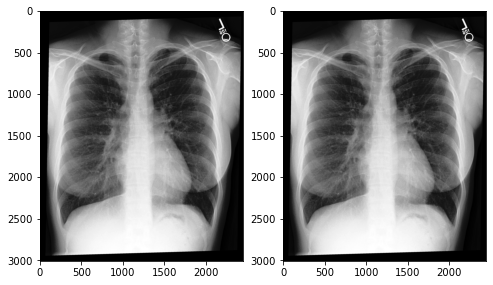

In [8]:
fig = plt.figure(figsize=(8, 16))
pth = ''




with Image.open(pth.replace('SStor1/zhanghex', 'MyDataStor2')) as img1:
    print(img1.size, img1.format)
    fig.add_subplot(1,2,1)
    plt.imshow(img1, cmap='gray')
with Image.open(pth) as img2:
    print(img2.size, img2.format)
    fig.add_subplot(1,2,2)
    plt.imshow(img2, cmap='gray')
    
plt.show()